# Sentiment Analysis on Student Feedback in Engineering Education

## Introduction

In the field of engineering education, student feedback plays a vital role in assessing the effectiveness of teaching methods, course materials, and overall learning experiences. Sentiment analysis, a key component of data science, offers a powerful approach to analyze and extract valuable insights from student feedback. <br>

The objective of this project is to perform sentiment analysis on the feedback provided by **300 level computer engineering students in the University of Ilorin (my course mates)**. By making use of natural language processing (NLP) techniques and machine learning algorithms, we aim to uncover sentiments expressed in the feedback and gain a comprehensive understanding of student perceptions, satisfaction, and areas of improvement.<br>

Through the analysis of student feedback, we can identify common themes, sentiment trends, and specific challenges faced by students. This valuable information can help inform the department and it's lectureres about the effectiveness of their teaching methodologies, course content, and student support systems. The insights derived from sentiment analysis on student feedback can drive evidence-based decision-making in engineering education. It enables the department to address concerns, make improvements, and create a positive learning environment that caters to the needs of the students.

## Data Collection
To get the data to use for this project, I utilized [Google Forms](https://docs.google.com/forms/d/e/1FAIpQLSeInhWFxECdegDDIYo7uY3-U-JHYyUDkTBQBw-KJxIvzYg_yA/viewform) to collect valuable feedback from students. The platform facilitated the collection of diverse responses, streamlined data collection, ensuring accuracy and efficiency in gathering student sentiments and  provided a comprehensive dataset for the sentiment analysis.

In [153]:
# import libraries and packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')
from PIL import Image

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Load the spaCy English model
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

In [154]:
# load the dataset and show first 5 rows
df = pd.read_csv('Sentiment Analysis on Student Feedback.csv')
df.head()

Timestamp Course Code  \
0  2023/05/21 3:29:49 AM MDT     CPE 321   
1  2023/05/21 3:39:59 AM MDT     CPE 331   
2  2023/05/21 3:57:54 AM MDT     CPE 321   
3  2023/05/21 4:52:08 AM MDT     CPE 321   
4  2023/05/21 5:24:33 AM MDT     CPE 321   

                                            Feedback Previous Experience  \
0  The man is too fast in his teaching,he clearly...                  No   
1     The class is dry but he really puts in efforts                 Yes   
2  The course is shit and it's a threat to my bra...                  No   
3               He no try at all, didn’t teach well.                  No   
4                   Ogbeni you sef know as e dae go                  Yes   

  Gender  Attendance Course Difficulty  \
0   Male     Regular       Challenging   
1   Male     Regular          Moderate   
2   Male     Regular       Challenging   
3   Male     Regular       Challenging   
4   Male  Occasional         Difficult   

                              Study Hours (per week)  Overall Satisfaction  \
0                                           21 hours                     5   
1                                                  7                     8   
2                                               7hrs                     4   
3                                                 12                     1   
4  How you want take study something wey you head...                     0   

  Department  Unnamed: 11  
0        Yes  20/30GR072   
1        Yes   19/30GR010  
2        Yes   20/30GR073  
3        Yes          NaN  
4        Yes          NaN

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Timestamp               100 non-null    object
 1   Course Code             100 non-null    object
 2   Feedback                100 non-null    object
 3   Previous Experience     100 non-null    object
 4   Gender                  100 non-null    object
 5   Attendance              100 non-null    object
 6   Course Difficulty       100 non-null    object
 7   Study Hours (per week)  100 non-null    object
 8   Overall Satisfaction    100 non-null    int64 
 9   Department              100 non-null    object
 10  Unnamed: 11             3 non-null      object
dtypes: int64(1), object(10)
memory usage: 8.7+ KB


## Data Cleaning
Here, I'm going to clean the dataset as it can be seen to have some quality issues.

In [156]:
df.columns

Index(['Timestamp', 'Course Code', 'Feedback', 'Previous Experience', 'Gender',
       'Attendance', 'Course Difficulty', 'Study Hours (per week)',
       'Overall Satisfaction', 'Department', 'Unnamed: 11'],
      dtype='object')

In [157]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Timestamp', 'Course Code', 'Feedback', 'Previous Experience', 'Gender',
       'Attendance', 'Course Difficulty', 'Study Hours (per week)',
       'Overall Satisfaction', 'Department', 'Unnamed: 11'],
      dtype='object')


In [158]:
# drop unncessary column
df = df.drop(['Unnamed: 11'], axis=1)

# Convert the column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the date and time into separate columns
df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time

# drop Timestamp column
df = df.drop(['Timestamp'], axis=1)

# corrections to "Study Hours (per week) column"
df['Study Hours (per week)'] = df['Study Hours (per week)'].str.extract(r'(\d+)').fillna(0).astype(int)

# replace 'LGBTQ 😂' with 'Male'
df['Gender'] = df['Gender'].replace('LGBTQ 😂', 'Male')

In [159]:
# overview of the data again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Course Code             100 non-null    object
 1   Feedback                100 non-null    object
 2   Previous Experience     100 non-null    object
 3   Gender                  100 non-null    object
 4   Attendance              100 non-null    object
 5   Course Difficulty       100 non-null    object
 6   Study Hours (per week)  100 non-null    int32 
 7   Overall Satisfaction    100 non-null    int64 
 8   Department              100 non-null    object
 9   Date                    100 non-null    object
 10  Time                    100 non-null    object
dtypes: int32(1), int64(1), object(9)
memory usage: 8.3+ KB


In [160]:
# preview random sample of the data
df.sample(5)

Course Code                                          Feedback  \
95     GSE 301                                easy and no wahala   
85     MEE 361                                              nice   
87     CPE 311                      the best course and lecturer   
39     CPE 381       why is a 1 unit course stressing our lives?   
30     CPE 331  The lecturer is good and his course is also good   

   Previous Experience  Gender Attendance Course Difficulty  \
95                 Yes  Female    Regular              Easy   
85                 Yes    Male    Regular              Easy   
87                 Yes  Female    Regular              Easy   
39                  No  Female  Irregular       Challenging   
30                  No  Female    Regular          Moderate   

    Study Hours (per week)  Overall Satisfaction Department        Date  \
95                       9                     8        Yes  2023-05-30   
85                      13                     9        Yes  2023-05-30   
87                      15                    10        Yes  2023-05-30   
39                       1                     1        Yes  2023-05-29   
30                      12                     8        Yes  2023-05-29   

        Time  
95  14:56:07  
85  14:46:29  
87  14:47:59  
39  15:36:57  
30  15:14:54

## Data Preprocessing
Cleaning and preprocessing the data by handling contractions, converting text to lower case removing stop words, punctuations, hashtags, numbers/digits and special characters and then tokenizing and lemmatizing the text.

In [161]:
# Function to handle contractions
def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'d": " would",
        "'ll": " will",
        "'m": " am"
    }

    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)

# Function to preprocess text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, hashtags, mentions, and special characters
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers/digits
    text = re.sub(r'\b[0-9]+\b\s*', '', text)
#     text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Handle contractions
    text = handle_contractions(' '.join(tokens))

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the 'Feedback' column
df['Processed_Feedback'] = df['Feedback'].apply(preprocess_text)

In [162]:
# lets check out the column
df['Processed_Feedback'][:10].to_frame()

Processed_Feedback
0  man fast teachinghe clearly doesnt know teach ...
1                        class dry really put effort
2     course shit threat brainthe teaching mode poor
3                               try didnt teach well
4                           ogbeni sef know e dae go
5  omo god judge ak sha dont take class like expe...
6                                           man good
7                                            e choke
8  teaching mode okay lecturer revision whats tau...
9  basically experience cpe isnt hard method empl...

## Language Detection
Detecting the type of language used in the feedback text.

In [165]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return None
    
df['Language'] = df['Processed_Feedback'].apply(detect_language)

In [166]:
df['Language'].unique()

array(['en', 'cy', 'so', 'sk', 'af', 'fr', 'hr', 'id', 'pt', 'de', 'pl',
       'es'], dtype=object)

In [167]:
language_mapping = {
    'en': 'English',
    'cy': 'Welsh',
    'so': 'Somali',
    'sk': 'Slovak',
    'af': 'Afrikaans',
    'fr': 'French',
    'hr': 'Croatian',
    'id': 'Indonesian',
    'pt': 'Portuguese',
    'it': 'Italian',
    'pl': 'Polish',
    'es': 'Spanish'
}

df['Language'] = df['Language'].map(language_mapping)
df['Language'].unique()

array(['English', 'Welsh', 'Somali', 'Slovak', 'Afrikaans', 'French',
       'Croatian', 'Indonesian', 'Portuguese', nan, 'Polish', 'Spanish'],
      dtype=object)

In [150]:
df

Course Code                                           Feedback  \
0      CPE 321  The man is too fast in his teaching,he clearly...   
1      CPE 331     The class is dry but he really puts in efforts   
2      CPE 321  The course is shit and it's a threat to my bra...   
3      CPE 321               He no try at all, didn’t teach well.   
4      CPE 321                   Ogbeni you sef know as e dae go    
..         ...                                                ...   
95     GSE 301                                 easy and no wahala   
96     CPE 321  terrible way of teaching with the I-dont-care ...   
97     CPE 341                                 do not like coding   
98     CPE 381   this practical is hard on top 1 unit course haba   
99     CPE 321              not the right way to teach, Mr Akanni   

   Previous Experience  Gender  Attendance Course Difficulty  \
0                   No    Male     Regular       Challenging   
1                  Yes    Male     Regular          Moderate   
2                   No    Male     Regular       Challenging   
3                   No    Male     Regular       Challenging   
4                  Yes    Male  Occasional         Difficult   
..                 ...     ...         ...               ...   
95                 Yes  Female     Regular              Easy   
96                  No  Female   Irregular         Difficult   
97                  No    Male   Irregular         Difficult   
98                  No  Female     Regular         Difficult   
99                  No    Male  Occasional         Difficult   

    Study Hours (per week)  Overall Satisfaction Department        Date  \
0                       21                     5        Yes  2023-05-21   
1                        7                     8        Yes  2023-05-21   
2                        7                     4        Yes  2023-05-21   
3                       12                     1        Yes  2023-05-21   
4                        0                     0        Yes  2023-05-21   
..                     ...                   ...        ...         ...   
95                       9                     8        Yes  2023-05-30   
96                       4                     0        Yes  2023-05-30   
97                       0                     0        Yes  2023-05-30   
98                       5                     0        Yes  2023-05-30   
99                       3                     0        Yes  2023-05-30   

        Time                                 Processed_Feedback   Language  
0   03:29:49  man fast teachinghe clearly doesnt know teach ...    English  
1   03:39:59                        class dry really put effort    English  
2   03:57:54     course shit threat brainthe teaching mode poor    English  
3   04:52:08                               try didnt teach well    English  
4   05:24:33                           ogbeni sef know e dae go      Welsh  
..       ...                                                ...        ...  
95  14:56:07                                        easy wahala     Somali  
96  14:57:17           terrible way teaching idontcare attitude    English  
97  15:02:16                                        like coding  Afrikaans  
98  15:03:39                practical hard top unit course haba    English  
99  15:05:02                          right way teach mr akanni    English  

[100 rows x 13 columns]

The language is not important in this analysis though as it is not consistent with the feedback text. So I'll drop the column.

### Feature Engineering

In [169]:
df['Char_Count'] = df['Processed_Feedback'].apply(len) # can also use df['Processed_Feedback'].str.len()
df['Word_Count'] = df['Processed_Feedback'].apply(lambda x: len(x.split()))
df = df.drop(['Language'], axis=1)

In [170]:
df.sort_values(by='Char_Count', ascending=False).head(10)

Course Code                                           Feedback  \
43     CPE 341  The teaching mode and environment is top tier ...   
9      CPE 321  Basically from my own experience, CPE 321 isn’...   
17     CPE 331  The course is actually well detailed in the ma...   
20     MEE 361  This lecturer really tried for us to be honest...   
5      CPE 321  Omo, God will judge AK sha.\nYou don’t take a ...   
11     CPE 321  The course is very very difficult and the lect...   
24     CPE 321  I felt the course was a bit rushed in terms of...   
13     CPE 321  The course isn’t supposed to be this difficult...   
16     CPE 321  The lecturer is fucking terrible. With his I-d...   
15     CPE 311  The lecturer is cool and calm. Her teaching me...   

   Previous Experience Gender Attendance Course Difficulty  \
43                  No   Male    Regular       Challenging   
9                   No   Male    Regular       Challenging   
17                  No   Male    Regular              Easy   
20                 Yes   Male    Regular          Moderate   
5                   No   Male    Regular         Difficult   
11                  No   Male    Regular         Difficult   
24                  No   Male    Regular       Challenging   
13                 Yes   Male    Regular       Challenging   
16                  No   Male    Regular         Difficult   
15                 Yes   Male    Regular              Easy   

    Study Hours (per week)  Overall Satisfaction Department        Date  \
43                       6                     5        Yes  2023-05-29   
9                        5                     3        Yes  2023-05-21   
17                      10                     7        Yes  2023-05-24   
20                      12                     7        Yes  2023-05-24   
5                        9                     1        Yes  2023-05-21   
11                       6                     0        Yes  2023-05-21   
24                       4                     1        Yes  2023-05-24   
13                       0                     2        Yes  2023-05-22   
16                       7                     0        Yes  2023-05-24   
15                       9                     9        Yes  2023-05-24   

        Time                                 Processed_Feedback  Char_Count  \
43  15:44:32  teaching mode environment top tier course requ...         201   
9   09:44:44  basically experience cpe isnt hard method empl...         146   
17  09:29:41  course actually well detailed material lecture...         117   
20  09:35:13  lecturer really tried u honest teaching hundre...          98   
5   05:31:57  omo god judge ak sha dont take class like expe...          97   
11  18:57:34  course difficult lecturer dey even make easy a...          96   
24  16:39:40  felt course bit rushed term teaching course al...          85   
13  02:42:44  course isnt supposed difficult lecturer taken ...          85   
16  09:27:51  lecturer fucking terrible idontcare attitude t...          79   
15  09:26:26  lecturer cool calm teaching method make easier...          64   

    Word_Count  
43          26  
9           21  
17          16  
20          15  
5           18  
11          14  
24          13  
13          12  
16          10  
15           9

## Sentiment scores and Labels
Calaculating the sentiment scores and it's corresponding labels.

**Important Note**

In the context of sentiment analysis, **subjectivity scores** can help distinguish between subjective statements that reflect personal opinions or emotions and objective statements that convey factual information. A high subjectivity score indicates a greater level of personal bias or opinion, while a low subjectivity score suggests a more objective or factual nature of the text.

Subjectivity is an important aspect to consider alongside polarity (sentiment) analysis, as it provides additional context and granularity in understanding the nature of the text and the subjective or objective nature of the statements being analyzed.
The interpretation of subjectivity scores depends on the specific context and objective of your analysis. In general, a high subjectivity score indicates a greater degree of personal opinion or bias expressed in the text. This can be valuable if you are interested in capturing and analyzing subjective or emotional content, such as in sentiment analysis.

However, if the goal is to analyze and classify objective or factual information, a low subjectivity score would be more desirable. A low subjectivity score suggests that the text contains more objective statements that are based on facts or present information without personal opinion or bias.

In [171]:
# Calculate sentiment scores
df['Sentiment_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate subjectivity scores
df['Subjectivity_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Map sentiment scores to sentiment labels
df['Sentiment_Label'] = df.apply(lambda row: 'Positive' if row['Sentiment_Score'] > 0 and row['Subjectivity_Score'] > 0.5 else 
                                        'Negative' if row['Sentiment_Score'] < 0 and row['Subjectivity_Score'] > 0.5 else 'Neutral', axis=1)

In [172]:
# lets checkout some random samples of the data
df.sample(5)

Course Code                              Feedback Previous Experience  \
35     CPE 311                                  good                 Yes   
71     CPE 341  thank God for my coding skills  bruh                 Yes   
85     MEE 361                                  nice                 Yes   
69     CPE 321     Akanni, you are a bad teacher wtf                  No   
23     CPE 321                                Awful                   No   

    Gender Attendance Course Difficulty  Study Hours (per week)  \
35  Female    Regular              Easy                      12   
71    Male    Regular          Moderate                      15   
85    Male    Regular              Easy                      13   
69    Male    Regular         Difficult                      10   
23    Male    Regular         Difficult                       4   

    Overall Satisfaction Department        Date      Time  \
35                     9        Yes  2023-05-29  15:22:59   
71                     9        Yes  2023-05-30  14:26:11   
85                     9        Yes  2023-05-30  14:46:29   
69                     0        Yes  2023-05-30  14:22:16   
23                     2        Yes  2023-05-24  09:48:15   

             Processed_Feedback  Char_Count  Word_Count  Sentiment_Score  \
35                         good           4           1              0.7   
71  thank god coding skill bruh          27           5              0.0   
85                         nice           4           1              0.6   
69       akanni bad teacher wtf          22           4             -0.6   
23                        awful           5           1             -1.0   

    Subjectivity_Score Sentiment_Label  
35            0.600000        Positive  
71            0.000000         Neutral  
85            1.000000        Positive  
69            0.833333        Negative  
23            1.000000        Negative

## Aspect-Based sentiment Analysis Metrics

### Summary statistics and metrics 

In [173]:
# Sentiment Analysis Metrics
sentiment_counts = df['Sentiment_Label'].value_counts()
average_sentiment_score = df['Sentiment_Score'].mean()
average_subj_score = df['Subjectivity_Score'].mean()
average_feedback_length = df['Char_Count'].mean()

# Descriptive Statistics
study_hours_stats = df['Study Hours (per week)'].describe()
overall_satisfaction_stats = df['Overall Satisfaction'].describe()

# Categorical Metrics
course_code_counts = df['Course Code'].value_counts()
department_counts = df['Department'].value_counts()
sentiment_distribution = df.groupby('Course Code')['Sentiment_Label'].value_counts(normalize=True)

# Print the calculated metrics
print("Sentiment Analysis Metrics:")
print(sentiment_counts)
print("Average Sentiment Score:", average_sentiment_score)
print("Average Subjectivity Score:", average_subj_score)
print('Average Length of Feedback:', average_feedback_length)
print("\nDescriptive Statistics - Study Hours:")
print(study_hours_stats)
print("\nDescriptive Statistics - Overall Satisfaction:")
print(overall_satisfaction_stats)
print("\nCategorical Metrics - Course Code Counts:")
print(course_code_counts)
print("\nCategorical Metrics - Department Counts:")
print(department_counts)
print("\nSentiment Distribution by Course Code:")
print(sentiment_distribution)

Sentiment Analysis Metrics:
Neutral     42
Positive    34
Negative    24
Name: Sentiment_Label, dtype: int64
Average Sentiment Score: 0.04988879870129869
Average Subjectivity Score: 0.5088712121212121
Average Length of Feedback: 31.8

Descriptive Statistics - Study Hours:
count    100.000000
mean       8.310000
std        5.506094
min        0.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       21.000000
Name: Study Hours (per week), dtype: float64

Descriptive Statistics - Overall Satisfaction:
count    100.000000
mean       5.100000
std        3.599944
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max       10.000000
Name: Overall Satisfaction, dtype: float64

Categorical Metrics - Course Code Counts:
CPE 321    31
CPE 311    13
CPE 341    13
CPE 381    12
CPE 331    11
MEE 361    10
GSE 301    10
Name: Course Code, dtype: int64

Categorical Metrics - Department Counts:
Yes    99
No      1
Name: Department, dtype: int64

Sent

### Analyzing the frequency of specific keywords or phrases in the feedback

In [174]:
# analyze the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['shit', 'difficult', 'terrible', 'okay', 'best', 'worst', 'good', 'try']

# Concatenate all the preprocessed feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Tokenize the text into individual words
tokens = all_feedback.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")


Frequency of 'shit': 1
Frequency of 'difficult': 4
Frequency of 'terrible': 5
Frequency of 'okay': 3
Frequency of 'best': 3
Frequency of 'worst': 2
Frequency of 'good': 8
Frequency of 'try': 1


### Text clustering to group similar feedback together

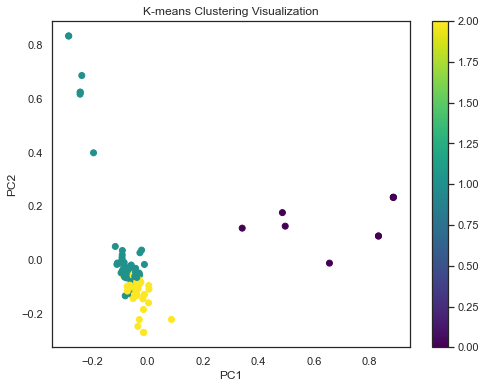

Top terms per cluster:
Cluster 0:
  nice
  course
  teaching
  scientist
  lecturer
  easy
  method
  job
  way
  go

Cluster 1:
  lecturer
  good
  teaching
  terrible
  course
  method
  like
  bad
  akanni
  class

Cluster 2:
  course
  stress
  easy
  well
  hard
  awful
  unit
  wahala
  plus
  dey



In [175]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization to the processed feedback text
tfidf_matrix = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform K-means clustering
num_clusters = 3  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to the feedback data
df['Cluster'] = kmeans.labels_

# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualization')
plt.colorbar()
plt.show()

# Print the top terms for each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"  {terms[ind]}")
    print()

## Topic Modeling
Implementing the topic modeling technique, **Latent Dirichlet Allocation (LDA)** to identify underlying topics or themes in the feedback data. This can provide deeper insights into the content and help analyze sentiment within specific topics.

In [176]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform LDA topic modeling
num_topics = 10  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names()
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0:
course lecturer difficult lecturer difficult hard time isnt teaching course difficult man

Topic 1:
course good lecturer nice terrible nice course easy course easy awful lecturer good

Topic 2:
course nice teaching lecturer method teaching method stress method lecturer nice teaching cool

Topic 3:
teaching code terrible course method teaching method bad love love code course taught

Topic 4:
time bad okay teaching teaching mode mode taught lecturer revision revision whats

Topic 5:
course make class dey especially dey make experience easy man pas

Topic 6:
akanni cool way god teach know really dry class dry know teach

Topic 7:
course easy awful wahala course hard hard good lecturer unit course unit

Topic 8:
lecturer course class course lecturer hate man wey plus lecturer good dey

Topic 9:
course lecturer god class student sha teaching coding like understand



## Emotion Detection

Identifying emotions in student feedback. The sentiment property of the TextBlob object to retrieve the sentiment scores which includes polarity (a value between -1 and 1 indicating the sentiment) and subjectivity (a value between 0 and 1 indicating the subjectivity of the text). <br>
**Emotion Polarity**: Emotion polarity measures the sentiment or emotional tone of a text. It indicates whether the text expresses a positive, negative, or neutral emotion. In the code provided, the polarity scores are obtained using the SentimentIntensityAnalyzer from NLTK. The polarity scores include values for positive, negative, and neutral sentiment. The sentiment polarity can help identify the overall sentiment or emotional tone of the feedback text. <br>
**Emotion Subjectivity**: Emotion subjectivity measures the degree of subjectivity or objectivity in the expression of emotions in a text. It indicates how much the text relies on personal opinions, beliefs, or experiences rather than factual or objective information. A higher subjectivity score suggests that the text is more influenced by personal perspectives or experiences.

In [177]:
def calculate_emotions(text):
    blob = TextBlob(text)
    emotion_scores = blob.sentiment.polarity, blob.sentiment.subjectivity
    return emotion_scores

# Apply emotion analysis to the feedback text
df['Emotion_Scores'] = df['Processed_Feedback'].apply(calculate_emotions)

# Extract emotion scores for each emotion category
df['Emotion_Polarity'] = df['Emotion_Scores'].apply(lambda x: x[0])
# df['Emotion_Subjectivity'] = df['Emotion_Scores'].apply(lambda x: x[1])

# assign emotion labels based on polarity values
df['Emotion_Label'] = df['Emotion_Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# the resulting dataframe with emotion scores and labels
df[['Processed_Feedback', 'Emotion_Polarity', 'Emotion_Label']].head()

Processed_Feedback  Emotion_Polarity  \
0  man fast teachinghe clearly doesnt know teach ...          0.150000   
1                        class dry really put effort          0.066667   
2     course shit threat brainthe teaching mode poor         -0.300000   
3                               try didnt teach well          0.000000   
4                           ogbeni sef know e dae go          0.000000   

  Emotion_Label  
0      Positive  
1      Positive  
2      Negative  
3       Neutral  
4       Neutral

## Exploratory Data Analysis
Creating meaningful visualizations to gain insights and communicate findings effectively. Exploring different types of plots, charts, and graphs to showcase various aspects of the data and also analyzing the distribution of sentiment labels in the data to understand the overall sentiment polarity.

### Correlation Analysis
Exploring the correlation between sentiment and other variables in the dataset to identify potential relationships.

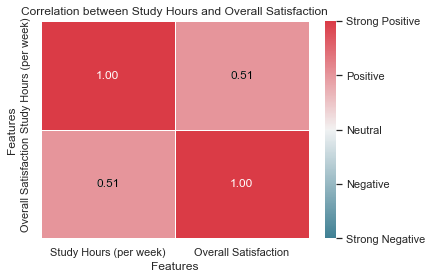

In [178]:
correlation_matrix = df[['Study Hours (per week)', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Study Hours and Overall Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

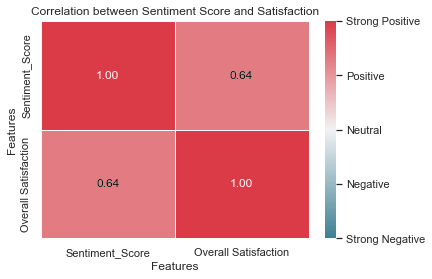

In [179]:
correlation_matrix = df[['Sentiment_Score', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Sentiment Score and Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

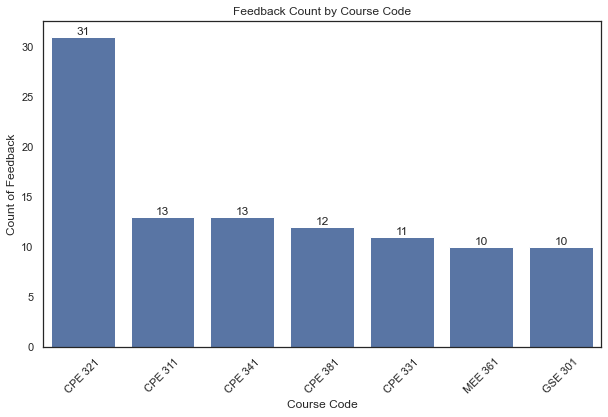

In [180]:
# Bar plot for Course Code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = df['Course Code'].value_counts().index
ax = sns.countplot(data=df, x='Course Code', color=color, order=order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Code')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

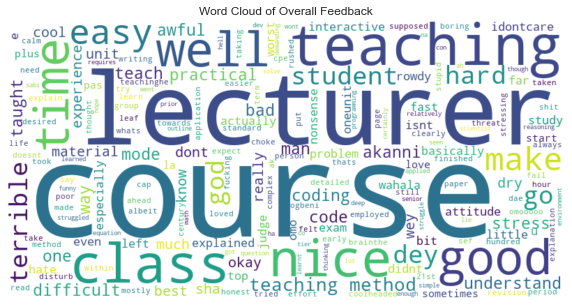

In [181]:
# Word cloud for Overall Feedback: Combine all feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Overall Feedback')
plt.show()

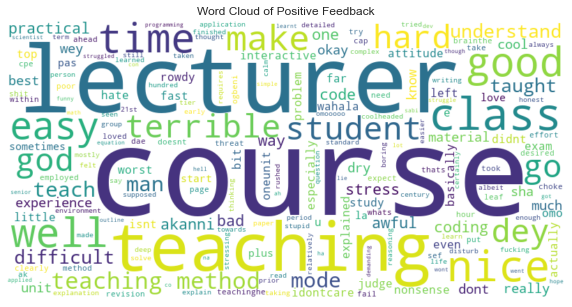

In [182]:
# Word cloud for Positive Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'Positive']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Feedback')
plt.show()

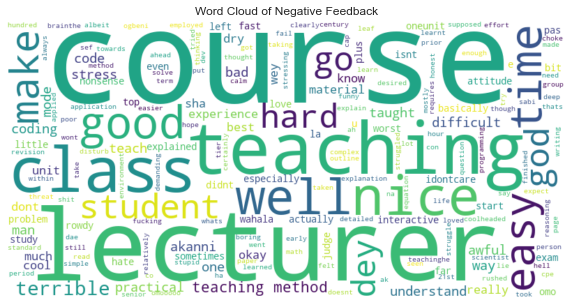

In [183]:
# Word cloud for Negative Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'Negative']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Feedback')
plt.show()

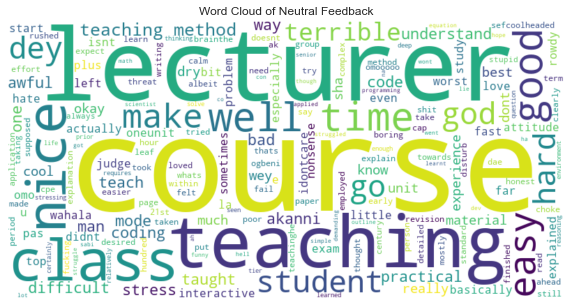

In [184]:
# Word cloud for Neutral Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'Neutral']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Feedback')
plt.show()

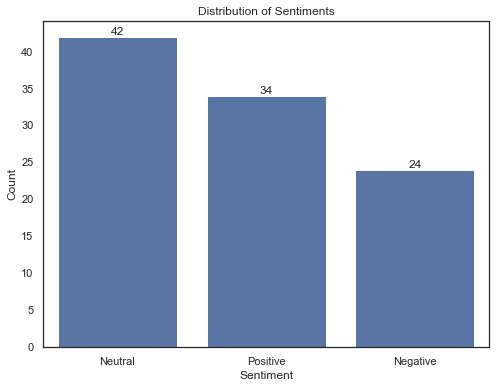

In [185]:
# Bar plot for Sentiment
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
order = df['Sentiment_Label'].value_counts().index
ax = sns.countplot(data=df, x='Sentiment_Label', color=color, order=order)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

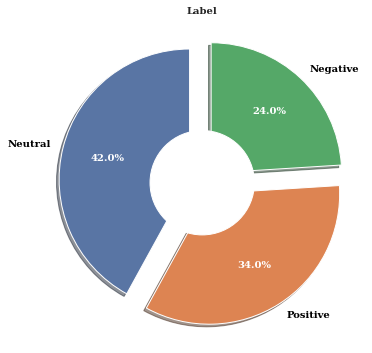

In [186]:
label_data = df['Sentiment_Label'].value_counts()
explode = (0.1, 0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,
                                                        labels = label_data.index,
                                                        colors = ['#5975A4', '#DD8452', '#55A868'],
                                                        pctdistance = 0.65,
                                                        shadow = True,
                                                        startangle = 90,
                                                        explode = explode,
                                                        autopct = '%1.1f%%',
                                                        textprops={ 'fontsize': 10,
                                                        'color': 'black',
                                                        'weight': 'bold',
                                                        'family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

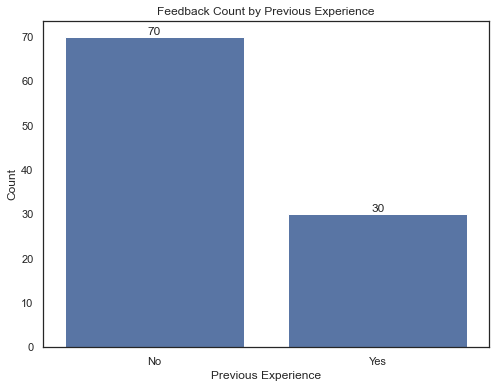

In [187]:
# Bar plot for Previous Experience
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
ax = sns.countplot(data=df, x='Previous Experience', color=color)
plt.xlabel('Previous Experience')
plt.ylabel('Count')
plt.title('Feedback Count by Previous Experience')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

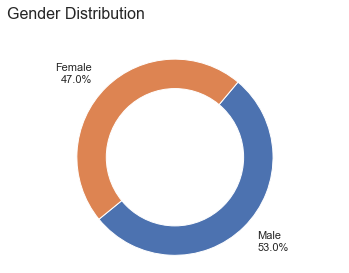

In [188]:
# Pie chart for Gender distribution
counts = df['Gender'].value_counts()
labels = [f"{gender}\n{count / len(df) * 100:.1f}%" for gender, count in counts.items()]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Gender Distribution', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

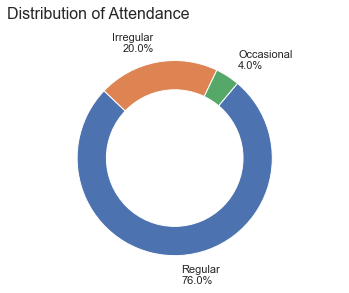

In [189]:
# Pie chart for Attendance
counts = df['Attendance'].value_counts()
labels = [f"{attendance}\n{count / len(df) * 100:.1f}%" for attendance, count in counts.items()]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Attendance', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

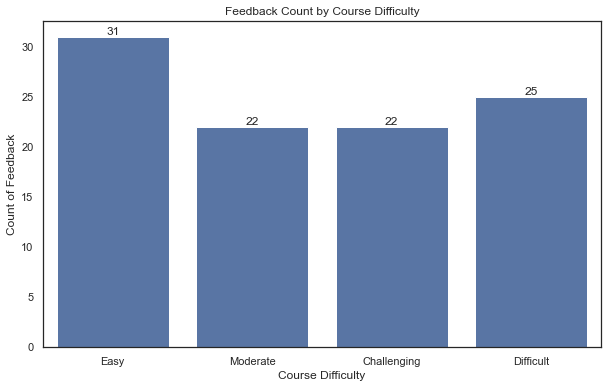

In [190]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
ax = sns.countplot(data=df, x='Course Difficulty', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show();

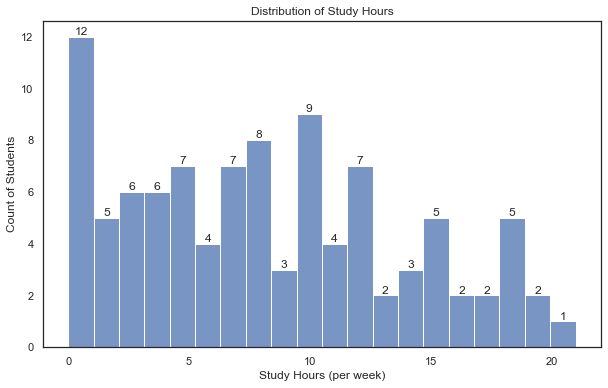

In [191]:
# Histogram for Study Hours (per week)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
ax = sns.histplot(data=df, x='Study Hours (per week)', bins=20, color=color)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Count of Students')
plt.title('Distribution of Study Hours')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

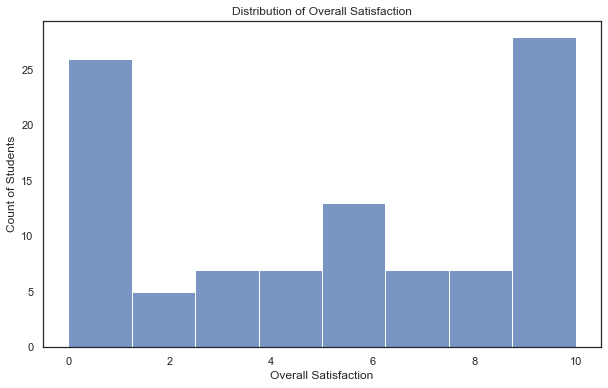

In [192]:
# Histogram for Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Overall Satisfaction')
plt.xlabel('Overall Satisfaction')
plt.ylabel('Count of Students')
plt.title('Distribution of Overall Satisfaction')
plt.show()

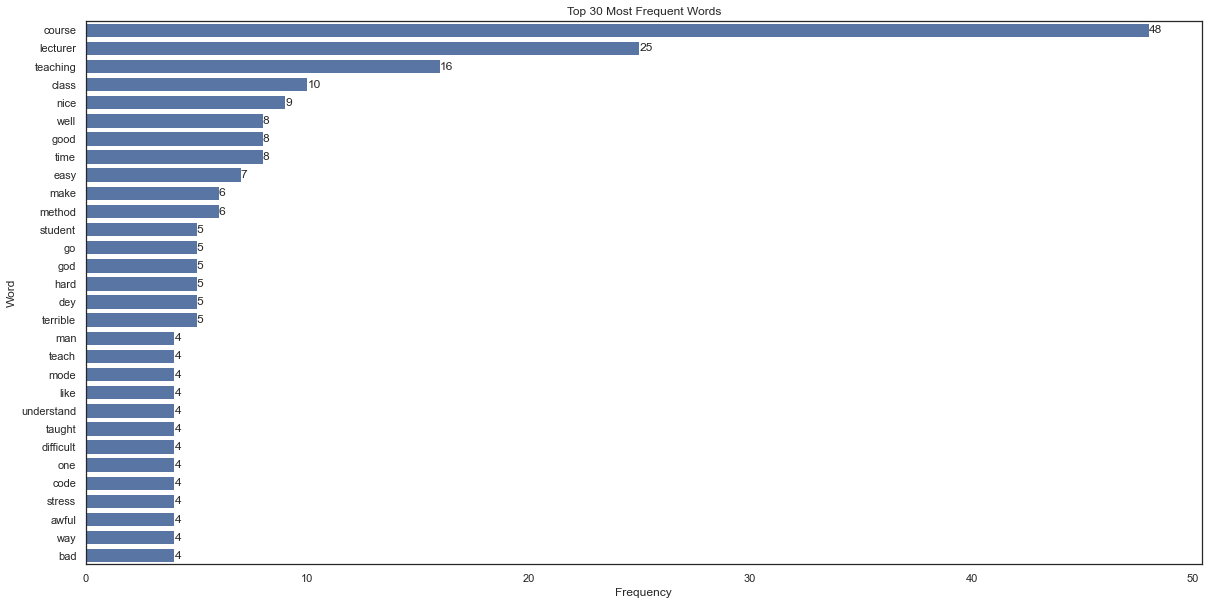

In [193]:
# Word Frequency Analysis
from collections import Counter
word_frequency = Counter(" ".join(df['Processed_Feedback']).split()).most_common(30)
plt.figure(figsize=(20, 10))
color = sns.color_palette()[0]
ax = sns.barplot(x=[word[1] for word in word_frequency], y=[word[0] for word in word_frequency], color=color)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 30 Most Frequent Words')
plt.show()

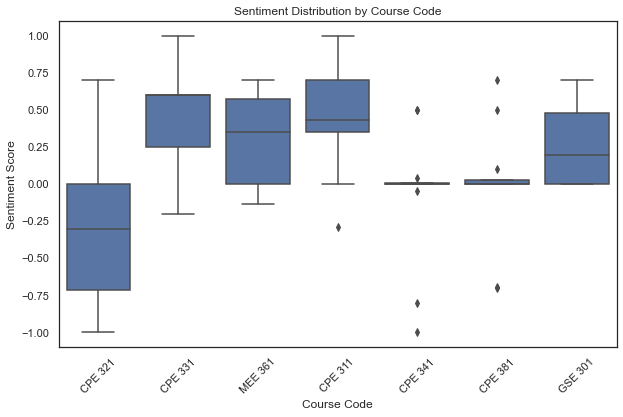

In [194]:
# Sentiment Box Plots
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Code', y='Sentiment_Score', color=color)
plt.xlabel('Course Code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution by Course Code')
plt.xticks(rotation=45)
plt.show()

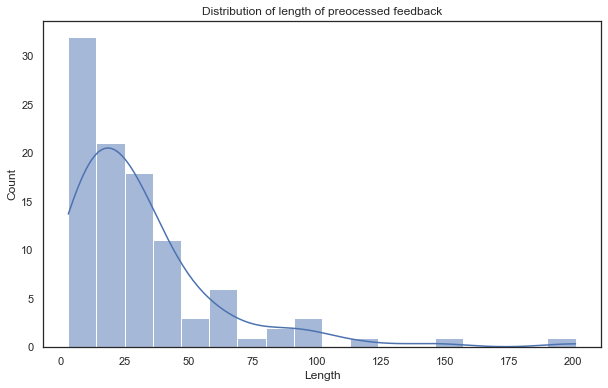

In [195]:
# Distribution of length of preocessed feedback
plt.figure(figsize=(10, 6))
sns.histplot(df['Char_Count'], kde = True, palette = 'hls')
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

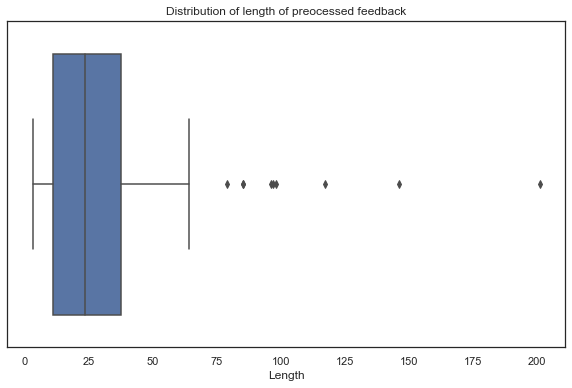

In [196]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['Char_Count'])
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.show()

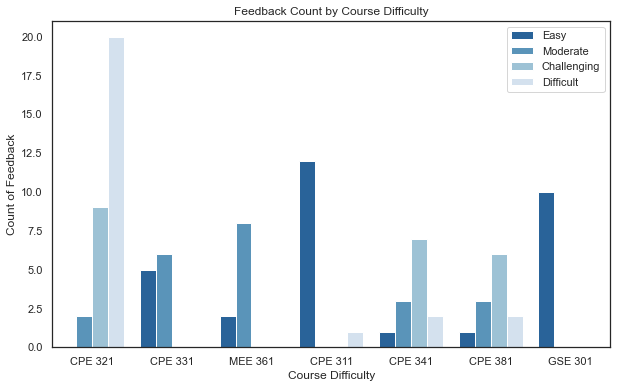

In [197]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Code', hue='Course Difficulty', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
plt.legend(loc=1)
plt.show();

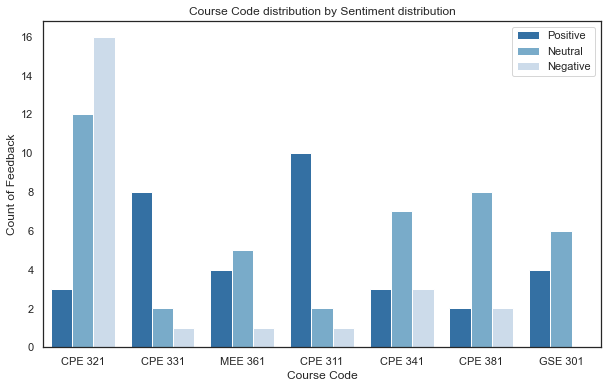

In [198]:
# Bar plot for Course Code distribution by Sentiment distribution
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Course Code', hue='Sentiment_Label', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Course Code distribution by Sentiment distribution')
plt.legend(loc=1)
plt.show();

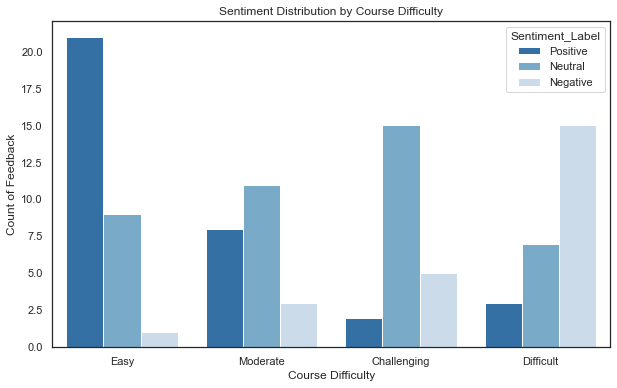

In [199]:
# Sentiment Distribution by Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Difficulty', hue='Sentiment_Label', 
              palette='Blues_r', hue_order=hue_order, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Course Difficulty')
plt.show()

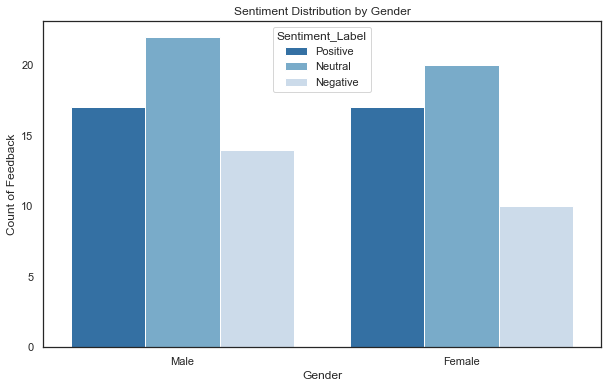

In [200]:
# Sentiment Distribution by Gender
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Gender', hue='Sentiment_Label', hue_order=hue_order, palette='Blues_r')
plt.xlabel('Gender')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Gender')
plt.show()

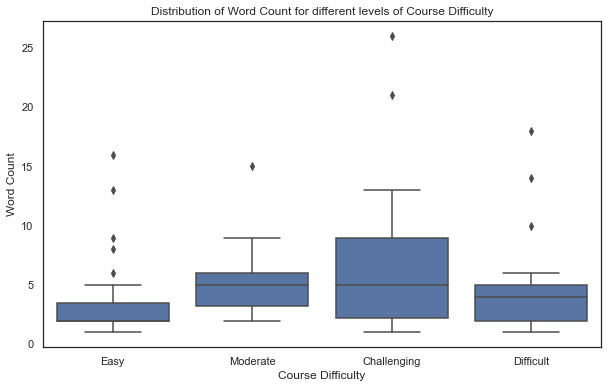

In [201]:
# Word Count distribution by course difficulty
plt.figure(figsize=(10, 6))
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Difficulty', y='Word_Count', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Word Count')
plt.title('Distribution of Word Count for different levels of Course Difficulty')
plt.show()

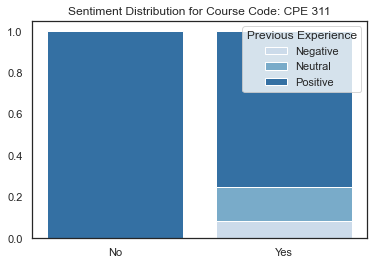

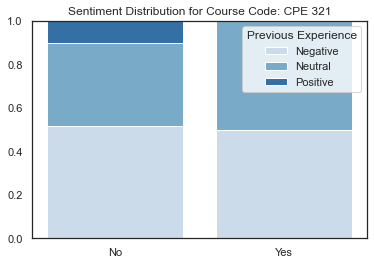

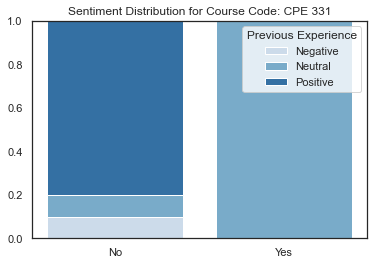

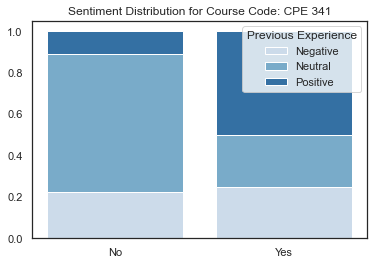

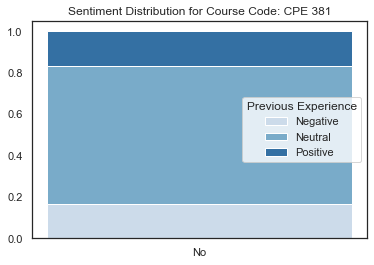

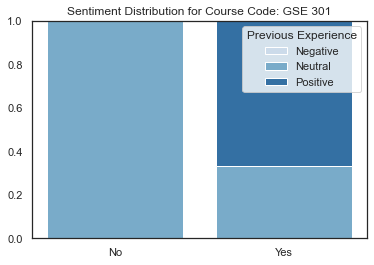

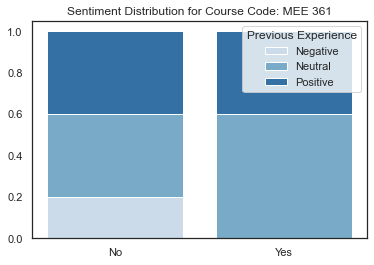

In [202]:
# Distribution of sentiment labels for different "Previous Experience" categories across various "Course Code" categories
subset_df = df[['Course Code', 'Previous Experience', 'Sentiment_Label']]

# Group the data by 'Course Code', 'Previous Experience', and 'Sentiment_Label' and count the occurrences
grouped_df = subset_df.groupby(['Course Code', 'Previous Experience', 'Sentiment_Label']).size().unstack(fill_value=0)

# Set the sentiment labels and their corresponding colors
sentiment_labels = ['Negative', 'Neutral', 'Positive']
colors = ['#CCDBEA', '#79ABC9', '#3470A3']

# Initialize the plot
fig, ax = plt.subplots()

# Loop through each 'Course Code' category
for i, course_code in enumerate(grouped_df.index.get_level_values('Course Code').unique()):
    # Get the data for the current 'Course Code'
    course_data = grouped_df.loc[course_code]
    
    # Calculate the relative frequency for each sentiment label
    total_counts = course_data.sum(axis=1)
    relative_freq = course_data.div(total_counts, axis=0)
    
    # Plot the stacked bar chart for each 'Previous Experience' category
    x = np.arange(len(course_data.index))
    bottom = np.zeros(len(course_data.index))
    for j, prev_exp in enumerate(relative_freq.columns):
        plt.bar(x, relative_freq[prev_exp], bottom=bottom, color=colors[j], label=prev_exp)
        bottom += relative_freq[prev_exp]
    
    # Adjust the x-axis labels
    plt.xticks(x, course_data.index)
    
    # Add a legend and set the title
    plt.legend(title='Previous Experience')
    plt.title(f'Sentiment Distribution for Course Code: {course_code}')
    
    # Show the plot
    plt.show()

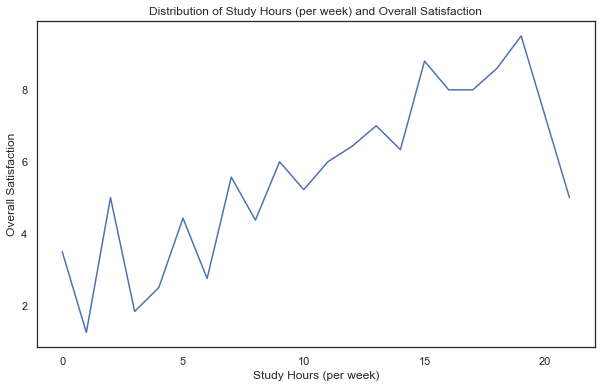

In [203]:
# Distribution of Study Hours (per week) and Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.lineplot(data=df, x='Study Hours (per week)', y='Overall Satisfaction', color=color, ci=None)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Overall Satisfaction')
plt.title('Distribution of Study Hours (per week) and Overall Satisfaction')
plt.show()

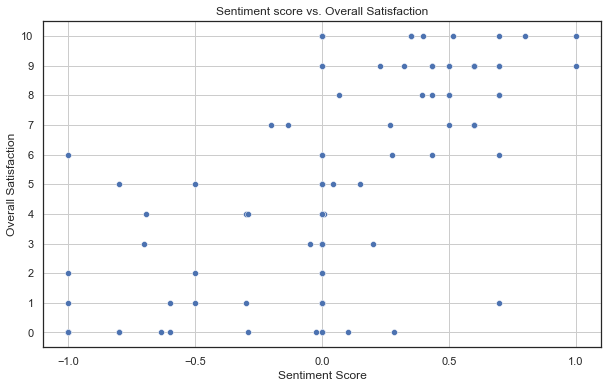

In [204]:
# Sentiment vs. Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.scatterplot(x='Sentiment_Score', y='Overall Satisfaction', data=df, color=color)
plt.xlabel('Sentiment Score')
plt.ylabel('Overall Satisfaction')
plt.title('Sentiment score vs. Overall Satisfaction')
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(0, 11))
plt.grid(True)
plt.show()

<Figure size 720x432 with 0 Axes>

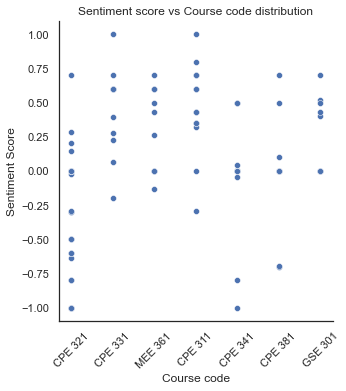

In [205]:
# Sentiment score Distribution by Course code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.relplot(data=df, x='Course Code',y = 'Sentiment_Score', color=color, kind='scatter')
plt.xlabel('Course code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment score vs Course code distribution')
plt.xticks(rotation=45)
plt.show();

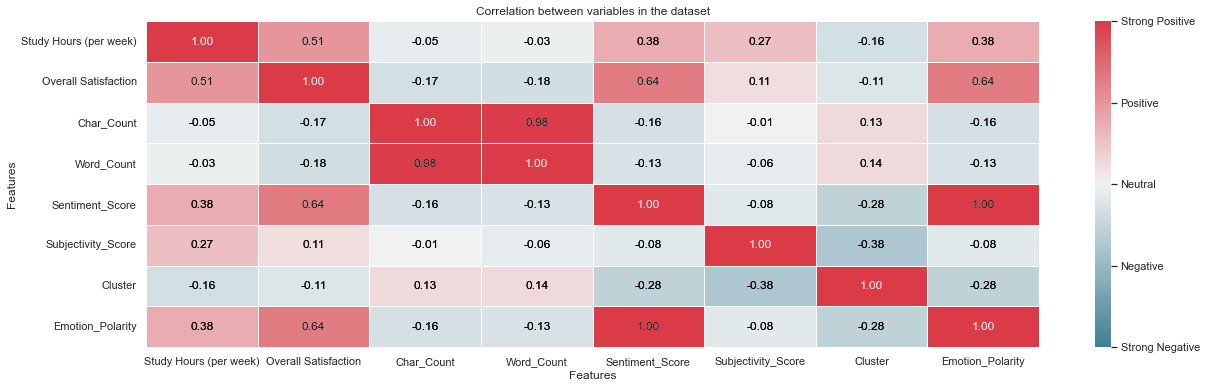

In [206]:
# correlation matrix of numerical variables in the data
correlation_matrix = df.corr()

plt.figure(figsize=[20, 6])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the dataset')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

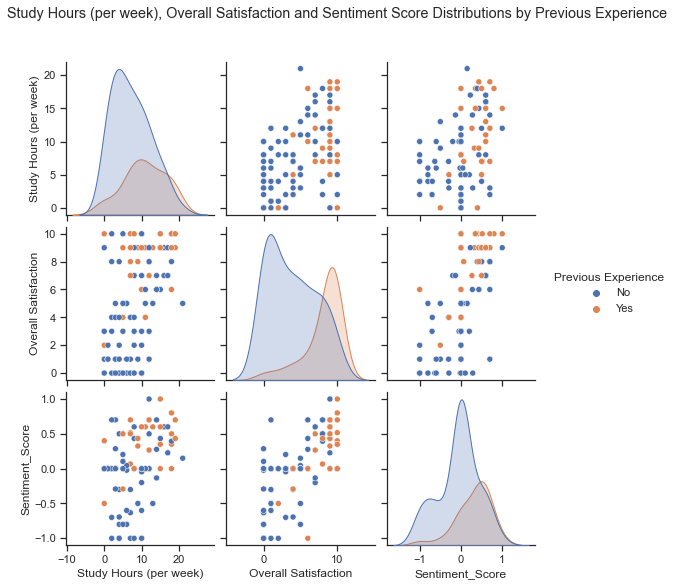

In [207]:
sns.set(style='ticks')
sns.pairplot(data=df, vars=['Study Hours (per week)', 'Overall Satisfaction', 
                            'Sentiment_Score'], hue='Previous Experience', markers='o')
plt.suptitle('Study Hours (per week), Overall Satisfaction and Sentiment Score Distributions by Previous Experience',
             y=1.08)
plt.show();

## Machine Learning Model
We build a ML model for predicting sentiment labels.

In [208]:
X = df['Processed_Feedback']
y = df['Sentiment_Label']

print(X.shape, y.shape)

(100,) (100,)


In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print(len(X_train), ',', len(y_train))
print(len(X_test), ',', len(y_test))

75 , 75
25 , 25


In [210]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [211]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

X_train_dtm, X_test_dtm

(<75x177 sparse matrix of type '<class 'numpy.int64'>'
 	with 328 stored elements in Compressed Sparse Row format>,
 <25x177 sparse matrix of type '<class 'numpy.int64'>'
 	with 101 stored elements in Compressed Sparse Row format>)

In [212]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

### Naive Bayes classifier 

In [213]:
nb = MultinomialNB()

# train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [214]:
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [215]:
print(accuracy_score(y_test, y_pred_class))

0.56


In [216]:
pipe = Pipeline([('bow', CountVectorizer()),
                                ('tfid', TfidfTransformer()),
                                ('model', MultinomialNB())])

In [217]:
pipe.fit(X_train, y_train)
y_pred_class = pipe.predict(X_test)
print(accuracy_score(y_test, y_pred_class))

0.6


In [218]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Encoded Target Labels:')
print(y_encoded, '\n')

# get mapping for each label
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mappings:')
print(le_name_mapping)

Encoded Target Labels:
[1 1 0 1 1 1 2 1 1 2 1 0 1 0 1 2 0 0 0 1 1 2 0 0 1 1 2 1 1 0 2 1 1 1 1 2 0
 2 0 1 2 1 0 2 2 0 2 0 1 0 1 0 1 0 2 1 2 1 1 1 1 2 0 2 1 1 1 2 2 0 2 1 1 2
 2 0 2 1 0 2 2 0 2 2 0 2 1 1 1 2 2 1 2 1 2 2 0 1 2 2] 

Label Mappings:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


### XGBoost Classifier

**Using random train and test subsets.**

In [233]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=80,
    use_label_encoder=False,
    objective='multi:softmax',
    eval_metric='merror',
    num_class=3
)

# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_classifier),
])

# Hyperparameter Tuning
param_grid = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__max_depth': [6, 8, 10],
    'model__n_estimators': [80, 100, 120],
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best parameters:', best_params)

# Fit and Evaluate on Testing Set
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Testing Accuracy:', acc)

Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 6, 'model__n_estimators': 80}
Testing Accuracy: 0.75


The testing accuracy of 0.75 suggests that the model is able to correctly classify 75% of the samples in the testing set which is good.

**Using Cross Validation.**

In [234]:
# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=80,
    use_label_encoder=False,
    objective='multi:softmax',
    eval_metric='merror',
    num_class=3
)

# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_classifier),
])

# Hyperparameter Tuning with Cross-Validation
param_grid = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__max_depth': [6, 8, 10],
    'model__n_estimators': [80, 100, 120],
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X, y_encoded)
best_params = grid_search.best_params_
print('Best parameters:', best_params)

# Fit and Evaluate using Cross-Validation
pipe.set_params(**best_params)
cv_scores = cross_val_score(pipe, X, y_encoded, cv=5)
mean_cv_score = cv_scores.mean()
print('Cross-validation accuracy:', mean_cv_score)

Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 8, 'model__n_estimators': 100}
Cross-validation accuracy: 0.6799999999999999





Following the analysis, I also created a Power BI report to communicate my findings which can be seen in the image below. 



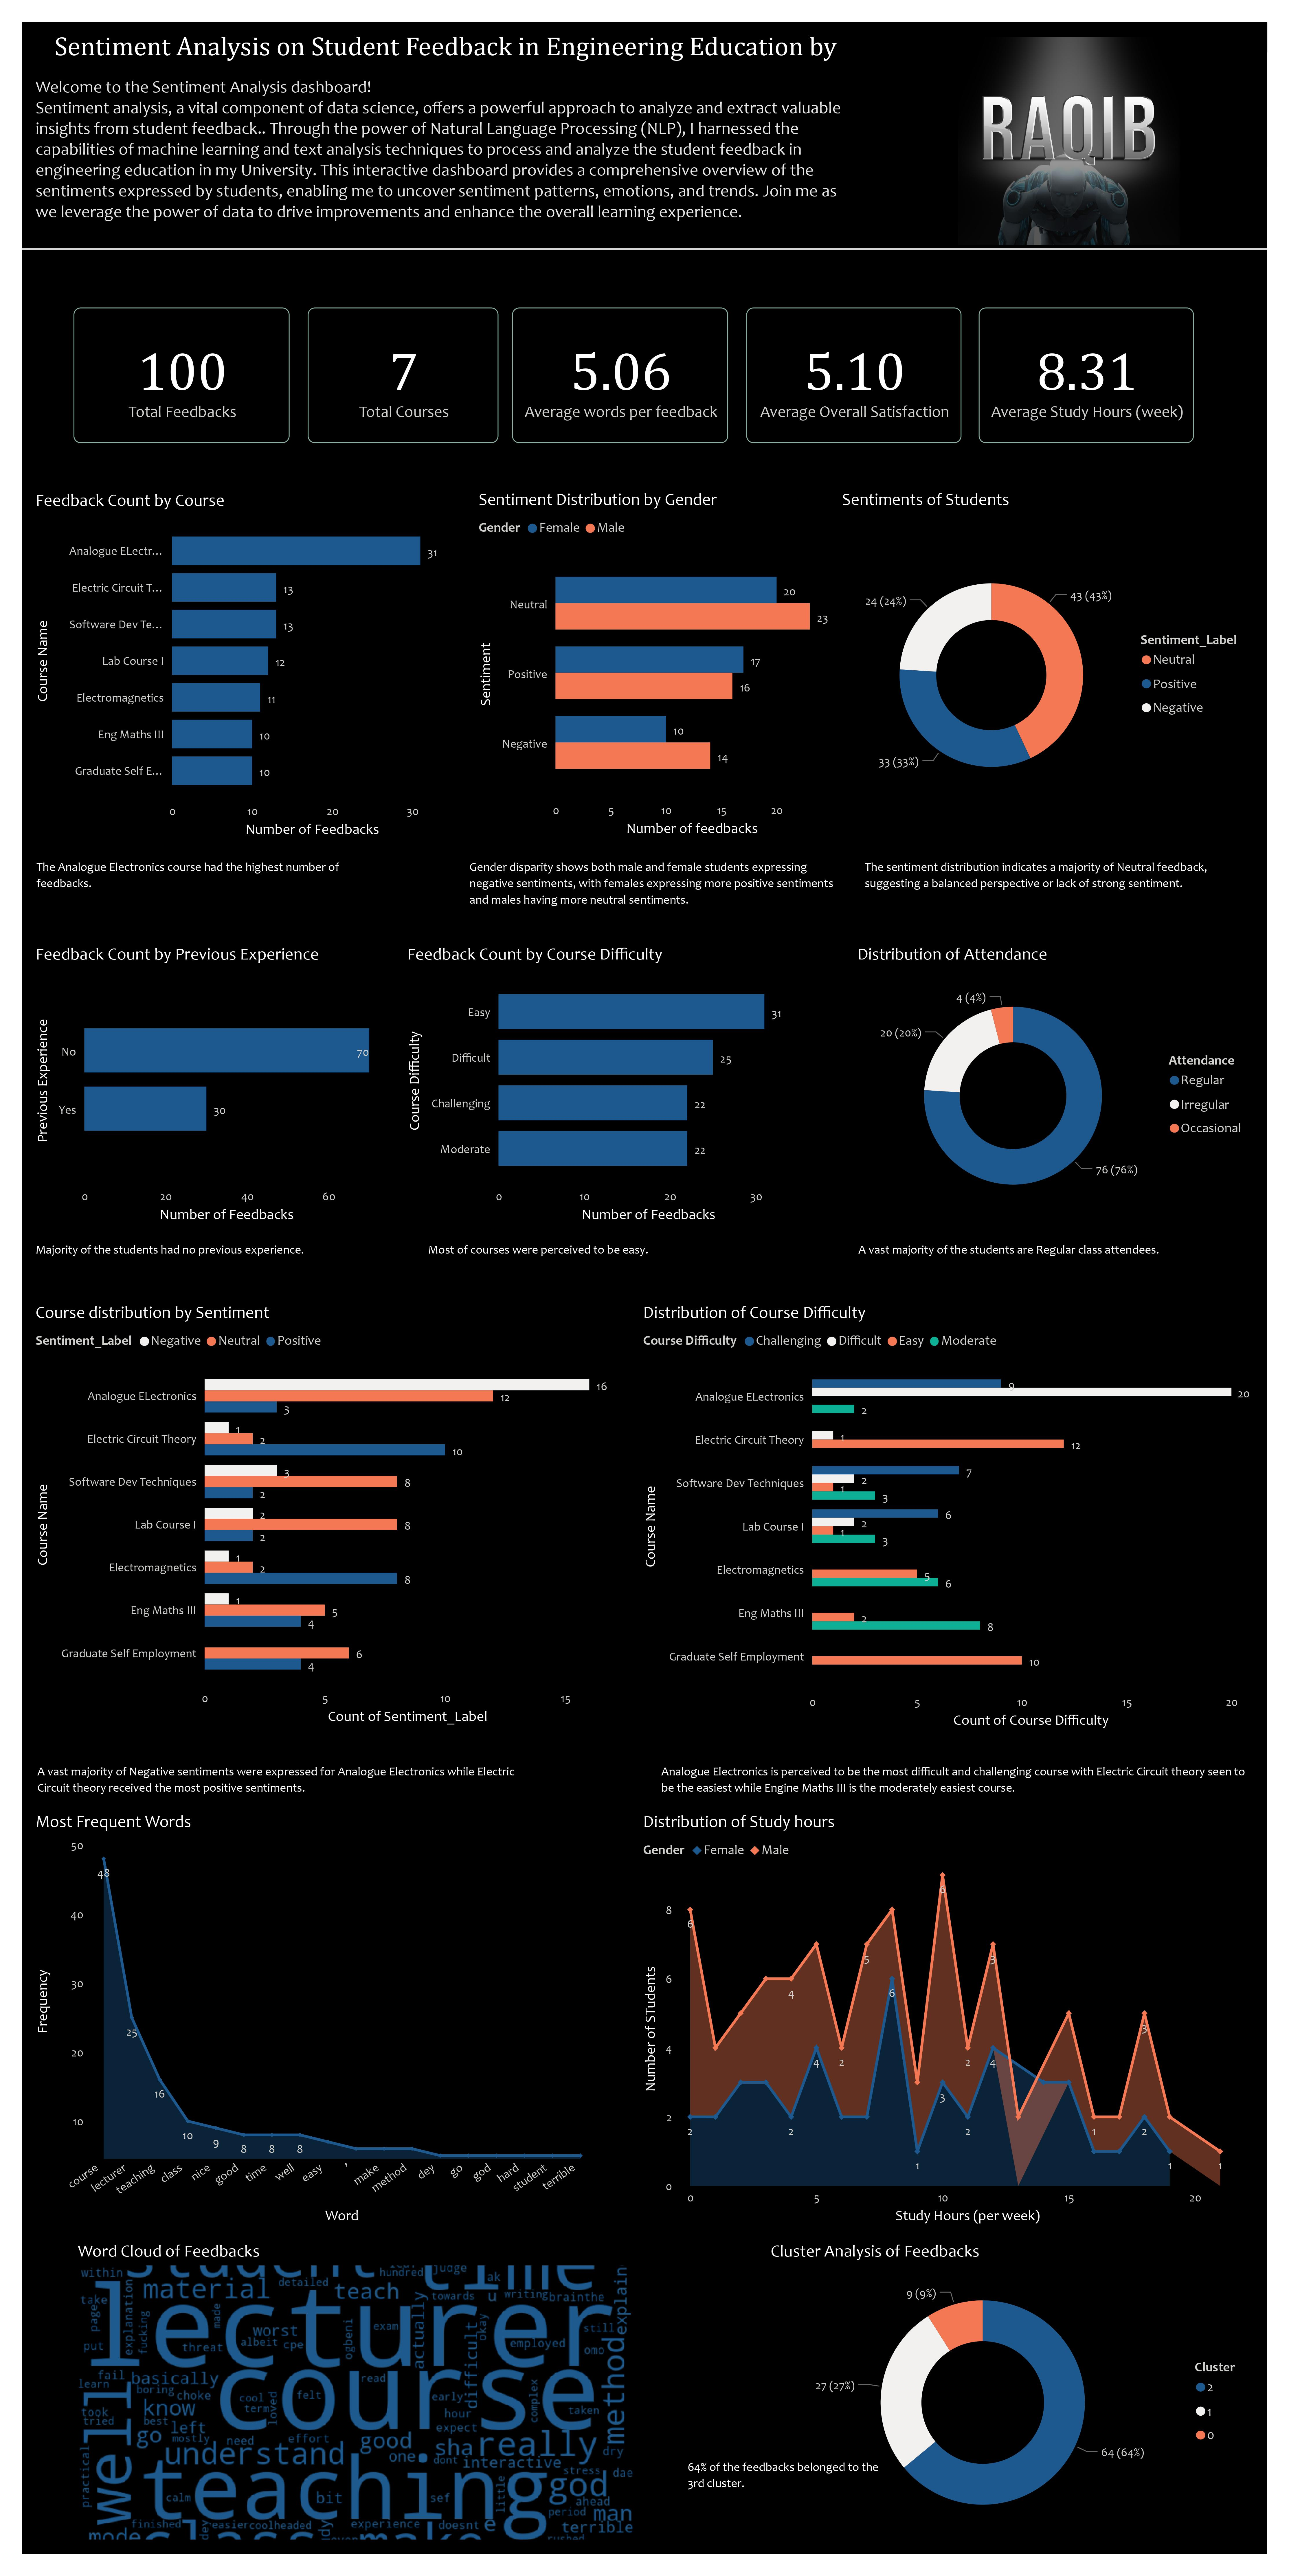

In [224]:
print('\n\n\nFollowing the analysis, I also created a Power BI report to communicate my findings which can be seen in the image below.', '\n')
from PIL import Image
Image.open('sentimentAnalysisViz.jpg')

## Conclusion

In conclusion, the sentiment analysis of student feedback in engineering education has yielded valuable insights and recommendations for improvement. The sentiment distribution indicates a majority of `Neutral` feedback (suggesting a balanced perspective or lack of strong sentiment towards their educational experience) followed by `Positive` and `Negative` sentiments. The prevalence of Neutral sentiments in the student feedback sentiment analysis may also indicate that students are providing objective observations or factual statements without expressing a clear positive or negative sentiment. Furthermore, it was observed that a majority of students had no previous experience, adding to the context of the analysis.

Gender disparity shows both male and female students expressing negative sentiments, with females expressing more positive sentiments and males having more neutral sentiments which highlight the importance of considering gender as a factor in understanding and addressing the sentiment dynamics in student feedback. 

Variation across courses highlights specific strengths or areas for improvement, with `CPE 321` being the most challenging. `CPE 341` and `CPE 311` received lower sentiment scores, while `CPE 311` had the highest sentiment score. It was also noted that the easy courses had the most number of positive sentiments. Correlations reveal the alignment of sentiment score with overall satisfaction and perfect correlation with emotion polarity. 

Additionally, the high correlation between study hours and overall satisfaction implies that the amount of time students dedicate to studying may positively influence their overall satisfaction with the courses they take. 

Topic modeling uncovers key themes discussed by students. These findings can serve as a basis for informed decision-making, allowing the department to address necessary concerns, capitalize on strengths, and continuously enhance the quality of education provided to students. The sentiment analysis serves as a foundation for continuous improvement in engineering education with targeted interventions required for courses with more negative sentiments, particularly `CPE 321` ensuring a fulfilling and satisfactory learning conditions for the students.

Lastly, I built a model which achieved impressive accuracy rates of 68% in cross-validation and 75% in testing. This project has deepened my understanding of ML and fueled my passion for using technology to understand and predict human emotions.